In [686]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from PIL import Image
sns.set()

In [650]:
data = pd.read_csv('disthistogram', header=0 , delimiter='\t', names=['Harmonic','Arithmetic','Geometric','VeinOrder','NN VeinOrder','v2x','v2y','vx','vy','v2width','vwidth'])
ven = pd.read_csv('venconnections', delimiter='\t')
ven2 = pd.read_csv('ven2connections', delimiter='\t')
im = Image.open('conprofile.png','r')
im2 = Image.open('covgrad.png','r')

x = data.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled, columns=data.columns)

ven.head()
ven.iloc[:,4].std()
data.iloc[0][5:9:2]
data.iloc[0][6:9:2]

In [651]:
cols = list(data.columns[1:7])
cols += list(data.columns[9:])
countdf = data.groupby(['vx','vy']).agg('count').drop(cols,axis=1).rename(columns={'Harmonic':'count'})
#countdf.head(5)
#countdf.index

In [652]:
copycountdf = countdf.copy()
#copycountdf['vx','vy'] = copycountdf.index
copycountdf.reset_index(level=0, inplace=True)
copycountdf.reset_index(level=0, inplace=True)

In [653]:
#copycountdf.head(5)

In [654]:
cdata = data.copy()
data = pd.merge(cdata,copycountdf,on=['vx','vy'])

Gerando um grafo a partir dos nodos das venações. Preciso encontrar uma representação que explique os dados que encontrei no outro notebook (picos que aparecem na derivada temporal da cobertura). Figura mostrada abaixo.

In [655]:
cven2 = ven2.copy()
cven2.rename(columns={'startx':'v2x','starty':'v2y'},inplace=True)
cven2 = cven2.groupby(by=['v2x','v2y']).agg('max').drop(['endx','endy'],axis=1)
cven2.reset_index(level=0,inplace=True)
cven2.reset_index(level=0,inplace=True)

In [679]:
cven = ven.copy()
cven.rename(columns={'startx':'vx','starty':'vy','disttoroot':'disttorootp'},inplace=True)
cven = cven.groupby(by=['vx','vy']).agg('max').drop(['endx','endy'],axis=1)
cven.reset_index(level=0,inplace=True)
cven.reset_index(level=0,inplace=True)

In [657]:
data = pd.merge(data,cven2,on=['v2x','v2y'])
#data = pd.merge(data,cven,on=['vx','vy'],how='left')

In [680]:
cvendata = cven.groupby(by=['vx','vy']).agg('max')
cvendata.reset_index(level=0,inplace=True)
cvendata.reset_index(level=0,inplace=True)

In [682]:
cvendata =  pd.merge(data,cvendata,on=['vx','vy'],how='right')

In [667]:
data.head()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder,v2x,v2y,vx,vy,v2width,vwidth,count,disttoroot
0,4.29036,4.45224,4.37033,2,2,23.4994,43.5266,22.6549,40.2965,0.306450,0.415382,40,3.08665
1,3.00892,3.45336,3.22778,3,2,23.4313,41.9949,22.6549,40.2965,0.124702,0.415382,40,4.60014
2,4.54526,4.77231,4.66138,2,2,21.9865,43.5687,22.6549,40.2965,0.246036,0.415382,40,4.56122
3,5.57531,5.67411,5.62485,2,2,22.0297,44.9813,22.6549,40.2965,1.270470,0.415382,40,3.00777
4,2.72355,3.07499,2.86141,3,2,24.4870,41.3656,22.6549,40.2965,0.095905,0.415382,40,5.50738


In [669]:
cvendata.head()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder,v2x,v2y,vx,vy,v2width,vwidth,count,disttoroot,disttorootp
0,3.08678,3.10645,3.09666,2.0,1.0,30.5052,42.6399,33.1149,41.75,0.084664,0.415382,27.0,8.64185,48.6982
1,4.44916,4.49584,4.47221,1.0,1.0,30.2325,44.4403,33.1149,41.75,1.359850,0.415382,27.0,8.87805,48.6982
2,3.93655,4.08174,4.00783,1.0,1.0,31.6544,44.4676,33.1149,41.75,1.354560,0.415382,27.0,10.28310,48.6982
3,3.68121,5.37979,4.41280,1.0,1.0,32.9631,43.9564,33.1149,41.75,1.349260,0.415382,27.0,11.52510,48.6982
4,2.93109,4.93772,3.79129,2.0,1.0,34.0035,43.2780,33.1149,41.75,0.072095,0.415382,27.0,12.13890,48.6982


In [727]:
Xtrain = np.array(cvendata['disttorootp'][pd.notna(cvendata['count'])]).reshape(-1,1)
Xtest = np.array(cvendata['disttorootp'][pd.isna(cvendata['count'])]).reshape(-1,1)
ytrain = np.array(cvendata['count'][pd.notna(cvendata['count'])]).reshape(-1,1)
ytest = np.array(cvendata['count'][pd.isna(cvendata['count'])]).reshape(-1,1)

In [728]:
print(Xtest.size,Xtrain.size,ytrain.size,ytest.size)

110 498 498 110


In [729]:
tree = DecisionTreeClassifier()
tree.fit(Xtrain,ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

ven2std = ven2.iloc[:,4].std()
ven2max = ven2.iloc[:,4].max()
ven2min = ven2.iloc[:,4].min()
normcm = (ven2max - ven2['disttoroot'])/(ven2max-ven2min)

In [732]:
cvendata['count'][pd.isna(cvendata['count']) ]= tree.predict(Xtest)

In [671]:
#data['disttoroot']

In [675]:
disc = list(data['disttoroot'].quantile(np.linspace(0,1,5)))

In [676]:
data['dtrootclass']=0
for i in range(0,len(disc)-1):
    data['dtrootclass'].loc[(data['disttoroot']>disc[i]) &  (data['disttoroot']<disc[i+1])] = float(i)+1.0

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


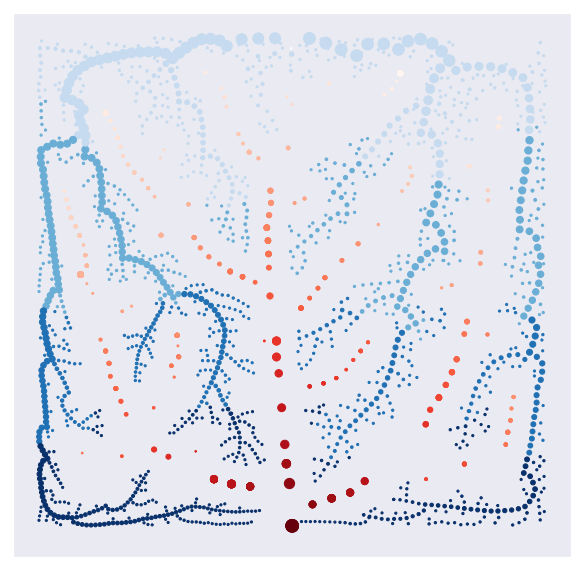

In [684]:
# @hidden_cell
fig = plt.figure(figsize=(10,10))
plt.scatter(data['v2x'],data['v2y'],s=np.power(10*np.array(data['v2width'])+2,1.79),c=data['dtrootclass'], cmap=plt.get_cmap('Blues'))
#plt.scatter(data['vx'],data['vy'],s=data['count']+np.power(3*np.array(data['vwidth']),2.82),c=(data['disttorootp'].max()-data['disttorootp'])/data['disttorootp'].std(), cmap=plt.get_cmap('Oranges'))
plt.scatter(cvendata['vx'],cvendata['vy'],s=cvendata['count']+np.power(3*np.array(cvendata['vwidth']),2.82),c=(cvendata['disttorootp'].max()-cvendata['disttorootp'])/cvendata['disttorootp'].std(), cmap=plt.get_cmap('Reds'))
#plt.scatter(cvendata['vx'],cvendata['vy'],c=(cvendata['disttorootp'].max()-cvendata['disttorootp'])/cvendata['disttorootp'].std(), cmap=plt.get_cmap('Reds'))
#for i in range(data.shape[0]):
#    plt.plot(data.iloc[i][5:9:2],data.iloc[i][6:9:2],'-r',linewidth=0.3,alpha=0.5)
#for i in range(ven.shape[0]):
#    plt.plot(ven.iloc[i][0:4:2],ven.iloc[i][1:4:2],'-o',c='sandybrown',markersize=1,linewidth=ven.iloc[i][4]/venstd,alpha=0.5)
#for i in range(ven2.shape[0]):
#    plt.plot(ven2.iloc[i][0:4:2],ven2.iloc[i][1:4:2],'-',c='cornflowerblue',linewidth=(ven2max - ven2.iloc[i][4])/ven2std + 0.5,alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

O grafo acima precisa de alguma forma representar o que vemos abaixo, o resultado da simulação.

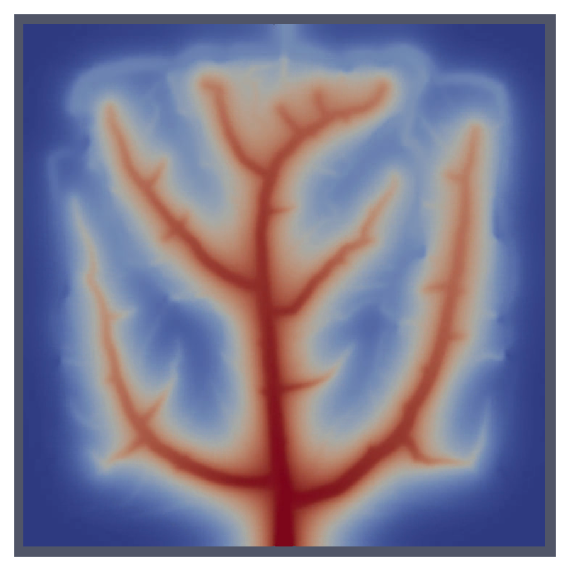

In [228]:
fig = plt.figure(figsize=(10,10))
plt.imshow(np.asarray(im))
plt.xticks([])
plt.yticks([])
plt.show()

Os picos que vemos abaixo são "bursts" no qual há um aumento grande na cobertura do corante. Provavelmente tem a ver com os nodos mais importantes da venação.

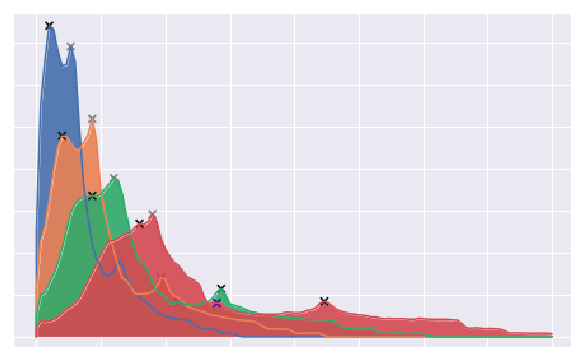

In [304]:
fig = plt.figure(figsize=(10,7))
plt.imshow(np.asarray(im2))
plt.xticks([])
plt.yticks([])
plt.show()

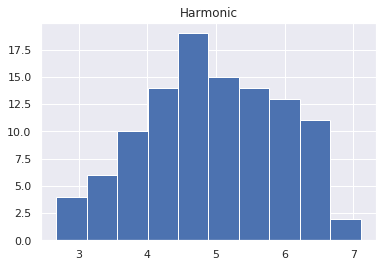

In [14]:
data.groupby(['VeinOrder','NN VeinOrder']).get_group((2,3)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1).hist(bins=10)
#plt.xlim(1,6)
plt.show()
#data['NN VeinOrder'].hist(bins=10)
#plt.xlim(1,5)
#plt.show()

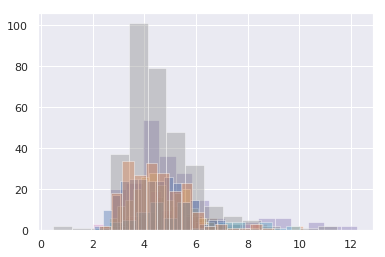

In [19]:
for i in range(1,5):
    for j in range(1,4):
        df = data.groupby(['VeinOrder','NN VeinOrder']).get_group((i,j)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
        sns.distplot(df, bins=15,hist=True, kde=False, rug=False)

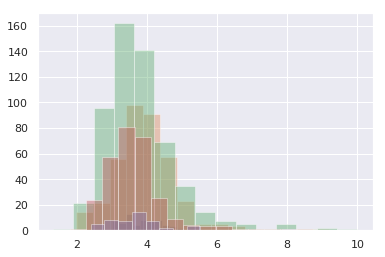

In [100]:
for i in range(1,6):
    df = data.groupby('VeinOrder').get_group(i).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
    sns.distplot(df, bins=15,hist=True, kde=False, rug=False)



In [53]:
data.describe()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.00000
mean,3.814889,4.091761,3.949626,2.908887,2.45183
std,0.950355,0.956059,0.949267,0.920163,0.77693
min,1.324530,1.804050,1.637970,1.000000,1.00000
25%,3.195470,3.515505,3.372795,2.000000,2.00000
50%,3.683680,3.983070,3.827150,3.000000,2.00000
75%,4.198680,4.506980,4.352100,3.500000,3.00000
max,9.997340,9.997340,9.997340,6.000000,4.00000


In [49]:
data.head()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
0,4.67798,4.72853,4.70258,2,2
1,4.64436,4.64436,4.64436,1,3
2,2.68025,3.43605,3.09173,2,2
3,4.92177,4.94629,4.93402,1,3
4,3.91793,4.11680,4.01123,3,2


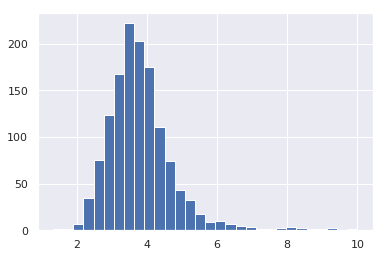

In [91]:
data['Harmonic'].hist(bins=30)
plt.show()


In [22]:
data.mean()

Distances Histogram    3.814889
dtype: float64

In [23]:
data.describe()

,Distances Histogram
count,1339.000000
mean,3.814889
std,0.950355
min,1.324530
25%,3.195470
50%,3.683680
75%,4.198680
max,9.997340


In [24]:
data.median()

Distances Histogram    3.68368
dtype: float64

In [28]:
data.kurtosis()

Distances Histogram    6.198549
dtype: float64

In [29]:
data.skew()

Distances Histogram    1.737346
dtype: float64